# Simple Barycenter Computation

In [1]:
from mmot import MMOTSolver

import numpy as np 
import matplotlib.pyplot as plt 
import itertools

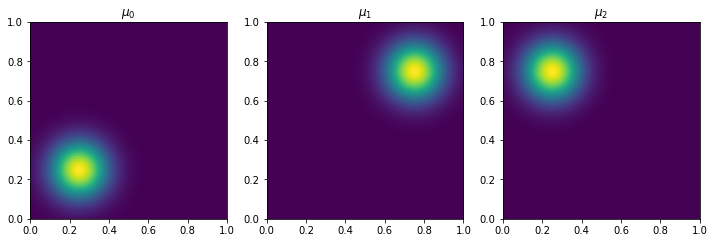

In [2]:
# Grid of size n1 x n2
n1 = 128   # x axis
n2 = 128  # y axis

x, y = np.meshgrid(np.linspace(0.5/n1,1-0.5/n1,n1), np.linspace(0.5/n2,1-0.5/n1,n2))

r = 0.125

positions = np.array([[0.25,0.25],
                      [ 0.75,0.75],
                      [0.25,0.75]])

# measures = [None]*len(positions)
measures = [None]*(len(positions))

for i in range(len(positions)):
    xc,yc = positions[i]
    measures[i] = np.zeros((n2, n1))
    measures[i] = np.exp(-0.5*((x-xc)**2 + (y-yc)**2)*100.0)
    measures[i][measures[i]<1e-4] = 0.0 

    measures[i] *= n1*n2 / np.sum(measures[i])

fig, ax = plt.subplots(1, len(measures), figsize=(12,4))
for i in range(len(measures)):
    ax[i].imshow(measures[i], origin='lower', extent=(0,1,0,1))
    ax[i].set_title("$\\mu_{{ {:0d} }}$".format(i))

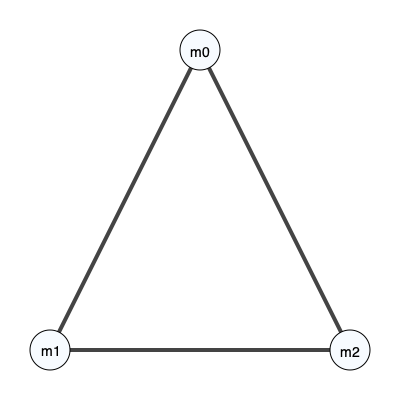

In [3]:
unroll_node = 0

# The set A that defines the pairwise costs
edge_list = [[0,1], [1,2], [0,2]]

bary_weights = np.array([1.0,1.0,1.0])
bary_weights /= np.sum(bary_weights)

prob = MMOTSolver(measures, edge_list, x, y, unroll_node, bary_weights)

prob.Visualize('original', filename='CostGraph.svg')

Iteration, StepSize,    Cost,   Error
        0,   0.2500,  0.0057,   1.99919
       10,   0.0593,  0.0368,   0.81437
       20,   0.0188,  0.0531,   0.26774
       30,   0.0106,  0.0547,   0.00155
       40,   0.0079,  0.0547,   0.00048
       50,   0.0106,  0.0547,   0.00030
       60,   0.0106,  0.0548,   0.00014
       70,   0.0079,  0.0548,   0.00008
       80,   0.0106,  0.0548,   0.00010
       90,   0.0106,  0.0548,   0.00004
      100,   0.0059,  0.0548,   0.00014
      110,   0.0059,  0.0548,   0.00003
      120,   0.0059,  0.0548,   0.00003
      130,   0.0059,  0.0548,   0.00002
      140,   0.0059,  0.0548,   0.00003
      150,   0.0059,  0.0548,   0.00002
      160,   0.0059,  0.0548,   0.00002
      170,   0.0059,  0.0548,   0.00001
      180,   0.0059,  0.0548,   0.00002
      190,   0.0059,  0.0548,   0.00001


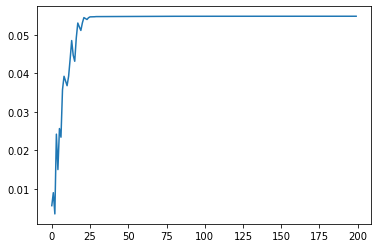

In [4]:
dual_vars = [np.zeros(x.shape) for i in range(prob.NumDual())]

num_its = 200
step_size = 0.25
root_node = 0
costs = np.nan*np.zeros(num_its)

ftol = 0.0
gtol = 0.0

root_nodes = np.arange(prob.NumDual())
root_cycler = itertools.cycle(root_nodes)

print('Iteration, StepSize,    Cost,   Error')
for i in range(num_its):
    error = prob.Step(next(root_cycler), dual_vars, step_size)
    
    costs[i] = prob.ComputeCost(dual_vars)
    if(i>0):
        step_size = prob.StepSizeUpdate(step_size, costs[i], costs[i-1], error)

    if((i%10)==0):
        print('{:9d},   {:0.4f},  {:0.4f},   {:0.5f}'.format(i,step_size, costs[i], error))

    # Check for convergence in cost
    if(np.abs(costs[i]-costs[i-1])<ftol):
        break

    # Check for convergence via gradient 
    if(error<gtol):
        break 
    
plt.figure()
plt.plot(costs)
plt.show()

In [5]:
weights = np.ones(len(measures))/len(measures)
bary = prob.Barycenter(dual_vars)


Text(0.5, 1.0, 'True Barycenter')

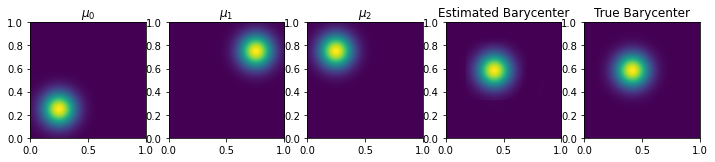

In [6]:
vmax = np.max(measures[0])
fig, axs = plt.subplots(1, len(measures)+2, figsize=(12,4))
for i in range(len(measures)):
    axs[i].imshow(measures[i], origin='lower', extent=(0,1,0,1))#, vmin=0, vmax=vmax)
    axs[i].set_title("$\\mu_{{ {:0d} }}$".format(i))
    
axs[-2].imshow(bary, origin='lower', extent=(0,1,0,1))#, vmin=0, vmax=vmax)
axs[-2].set_title('Estimated Barycenter')

true_loc = np.mean(positions,axis=0)
true_bary = np.zeros((n2, n1))
true_bary = np.exp(-0.5*((x-true_loc[0])**2 + (y-true_loc[1])**2)*100.0)
true_bary *= n1*n2 / np.sum(true_bary)

#true_bary[(x-true_loc[0])**2 + (y-true_loc[1])**2 < r**2] = 1
#true_bary *= n1*n2 / np.sum(true_bary)

axs[-1].imshow(true_bary, origin='lower', extent=(0,1,0,1))#, vmin=0, vmax=vmax)
axs[-1].set_title('True Barycenter')


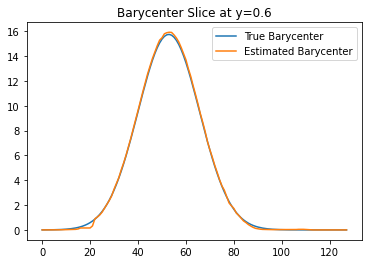

In [7]:
plt.plot(true_bary[int(0.6*n1),:],label='True Barycenter')
plt.plot(bary[int(0.6*n1),:],label='Estimated Barycenter')
plt.title('Barycenter Slice at y=0.6')
plt.legend()